# K-means clustering of fitbit heart rate data

In [1]:
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

In [3]:
# https://hackanons.com/2020/12/python-extract-data-from-json-file.html
def open_file(file):
    with open("json_files/"+file) as f:
        json_data = json.load(f)
    return json_data

# print(json_data)

In [4]:
# https://www.geeksforgeeks.org/python-accessing-key-value-in-dictionary/
# print ("Dict keys 1 are : ")
# dict_keys1 = [k for k in json_data[0]]
# print(dict_keys1)

# values1 = [json_data[0][k] for k in json_data[0]]
# print ("Dict keys 2 are : ")
# dict_keys2 = [k for k in values1[1]]
# print(dict_keys2)

# print ("Values are : ")
# values2 = [values1[1][k] for k in values1[1]]
# print(values2)

# # And then we are interested in values2[0]

# heart_rate = np.zeros(len(json_data))

# for i in range(len(json_data)):
#     values1 = [json_data[i][k] for k in json_data[i]]
#     values2 = [values1[1][k] for k in values1[1]]
#     heart_rate[i] = values2[0]

In [5]:
# First approximation to obtain heart rate data
# Note this does not consider the time axis in a consistent manner.

def extract_hr(json_data):
    heart_rate = np.zeros(len(json_data))

    for i in range(len(json_data)):
        values1 = [json_data[i][k] for k in json_data[i]]
        values2 = [values1[1][k] for k in values1[1]]
        heart_rate[i] = values2[0]
        
    return heart_rate

# Simple idea. Divide data in ~5s time bins, obtain average of heart rate and standard deviation. Plot this in a 2D plot. Use K-means to classify.

In [6]:
# Function that separates a string where the separator is

# https://stackoverflow.com/questions/4697006/python-split-string-by-list-of-separators
def split(txt, seps):
    default_sep = seps[0]

    # we skip seps[0] because that's the default separator
    for sep in seps[1:]:
        txt = txt.replace(sep, default_sep)
    return [i.strip() for i in txt.split(default_sep)]

In [7]:
# Extract different time formats arrays from json

def splitting_data(json_data):
    
    dict_keys1 = [k for k in json_data[0]]
    times = [json_data[k][dict_keys1[0]] for k in range(len(json_data))] # dateTime
    
    only_time = [split(times[k], ' ')[1] for k in range(len(times))]
    hms = [split(only_time[k], ":") for k in range(len(times))] #hour minute second

    # The index will represent the second of the day. Total of 86 400 seconds in one day

    # Converting the time to the number of second of the day
    seconds = [int(hms[k][0])*3600 + int(hms[k][1])*60 + int(hms[k][2]) for k in range(len(hms))]

    return times, only_time, hms, seconds

In [8]:
# times, only_time, hms, seconds = splitting_data(json_data)

# print(times[0])
# print(only_time[0])
# print(hms[0])
# print(seconds[0])

In [9]:
# print(only_time[7900])
# print(hms[7900])
# print(np.argmin(seconds))

In [10]:
# print(times[7899])

# print(times[7900])

Good to know, we are handling data from two days. Not everything in this file corresponds to the day 8/31/2021

In [11]:
# First challenge, divide everything in 5min time bins, that is in 5*60 = 300 s time bins!
def data_5s(json_data):
    
    times, only_time, hms, seconds = splitting_data(json_data)
    
    vecs_sec = []
    vecs_indices = []

    for i in range(288): # Number of 5 min periods in 24 hours
        vec_sec = []
        vec_indices = []
        banner = False

        for index_i in range(7900): # len(indices)

            if i*300 <= seconds[index_i] and seconds[index_i] < (i+1)*300:
                vec_sec.append(seconds[index_i])
                vec_indices.append(index_i)
                banner = True

            elif banner == True:
                vecs_sec.append(vec_sec)
                vecs_indices.append(vec_indices)
                break
                
    return vecs_sec, vecs_indices

In [12]:
def obtain_time_series(file_name):
    json_data = open_file(file_name)
    
    times, only_time, hms, seconds = splitting_data(json_data)
    # Seconds has the correct x-entries for the heart rate time series
    
    heart_rate = np.zeros(len(json_data))

    for i in range(len(json_data)):
        values1 = [json_data[i][k] for k in json_data[i]]
        values2 = [values1[1][k] for k in values1[1]]
        heart_rate[i] = values2[0]
        
    return np.asarray(seconds), heart_rate

In [13]:
# Magic number, number of seconds in one day 
print(300*288)
print(24*3600)

86400
86400


In [14]:
# Obtain the heart rate mean of these intervals as well as their standard deviation

def obtain_data(file_name):
    json_data = open_file(file_name)
    
    vecs_secs, vecs_indices = data_5s(json_data)
    
    means  = np.zeros(len(vecs_indices))
    stdevs = np.zeros(len(vecs_indices))
    
    heart_rate = np.zeros(len(json_data))

    for i in range(len(json_data)):
        values1 = [json_data[i][k] for k in json_data[i]]
        values2 = [values1[1][k] for k in values1[1]]
        heart_rate[i] = values2[0]

    for i in range(len(vecs_indices)):
        means[i] = np.mean(heart_rate[vecs_indices[i]]) # Wait, when did you define: heart_rate_31_8 ???
        stdevs[i] = np.std(heart_rate[vecs_indices[i]])
        
    return means, stdevs

In [48]:
with open("json_files/heart_rate-2021-08-31.json") as f:
    json_data = json.load(f)
json_data

[{'dateTime': '08/31/21 05:00:03', 'value': {'bpm': 61, 'confidence': 3}},
 {'dateTime': '08/31/21 05:00:08', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '08/31/21 05:00:23', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '08/31/21 05:00:28', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '08/31/21 05:00:43', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '08/31/21 05:00:58', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '08/31/21 05:01:03', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '08/31/21 05:01:13', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '08/31/21 05:01:28', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '08/31/21 05:01:33', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '08/31/21 05:01:38', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '08/31/21 05:01:43', 'value': {'bpm': 61, 'confidence': 3}},
 {'dateTime': '08/31/21 05:01:53', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '08/31/21 0

In [15]:
means_31_8, stdevs_31_8 = obtain_data("heart_rate-2021-08-31.json") # means, stdevs
means_01_9, stdevs_01_9 = obtain_data("heart_rate-2021-09-01.json")
means_02_9, stdevs_02_9 = obtain_data("heart_rate-2021-09-02.json")

seconds_31_8, heart_frequency_31_8 = obtain_time_series("heart_rate-2021-08-31.json")
seconds_01_9, heart_frequency_01_9 = obtain_time_series("heart_rate-2021-09-01.json")
seconds_02_9, heart_frequency_02_9 = obtain_time_series("heart_rate-2021-09-02.json")

# Why is there a line that crosses from the first point to the last one?

Because the time series is in that manner, when it reaches midnight, a new day starts, but the plot just starts back at 0 instead of continuing to hour 25.

Maybe you could generate a big array concatenating multiple arrays. And then separating them at 10 in the morning or such. So you can also have complete sleep periods.

In [16]:
seconds_31_8

array([18003, 18008, 18023, ..., 17960, 17975, 17990])

In [17]:
print(24*3600)

86400


In [18]:
for i in range(len(seconds_31_8)):
    if i > 7899:
        seconds_31_8[i] = seconds_31_8[i] + 86400 # BEcause it actually corresponds to the next day

In [19]:
shift = 24


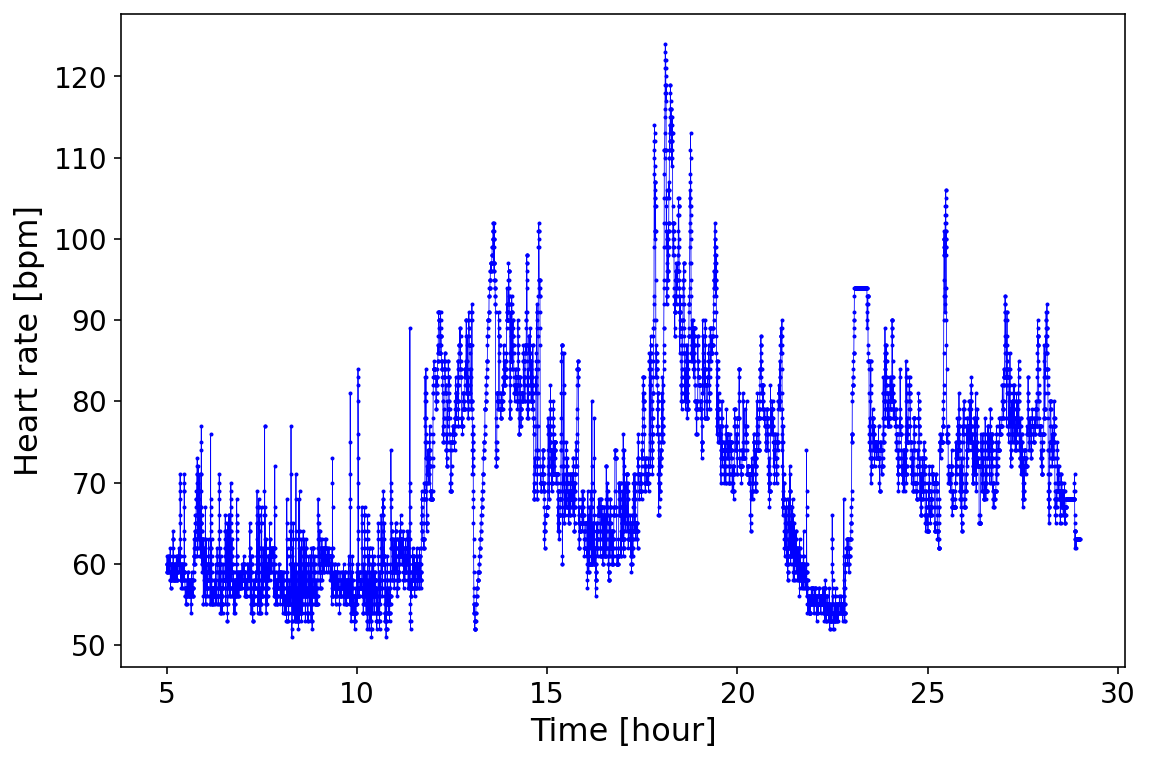

In [20]:
plt.figure(figsize= (9,6))
plt.plot(seconds_31_8/3600, heart_frequency_31_8, c="b", marker=".", linewidth=0.4, markersize=2)
# plt.plot(seconds_01_9/3600, heart_frequency_01_9, c="k")
# plt.plot(seconds_02_9/3600, heart_frequency_02_9, c="r")
plt.xlabel("Time [hour]")
plt.ylabel("Heart rate [bpm]")
plt.show()

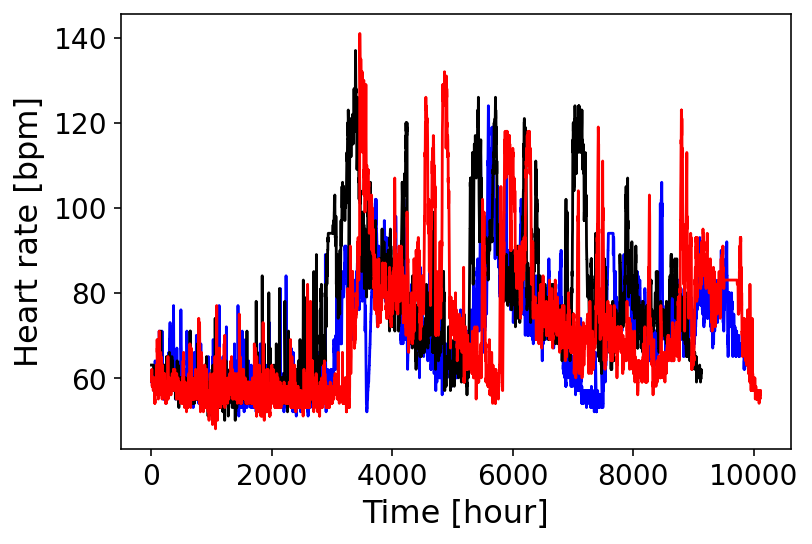

In [21]:
plt.plot(heart_frequency_31_8, c="b")
plt.plot(heart_frequency_01_9, c="k")
plt.plot(heart_frequency_02_9, c="r")
plt.xlabel("Time [hour]")
plt.ylabel("Heart rate [bpm]")
plt.show()

In [22]:
means_31_8, stdevs_31_8 = obtain_data("heart_rate-2021-08-31.json")
means_01_9, stdevs_01_9 = obtain_data("heart_rate-2021-09-01.json")
means_02_9, stdevs_02_9 = obtain_data("heart_rate-2021-09-02.json")

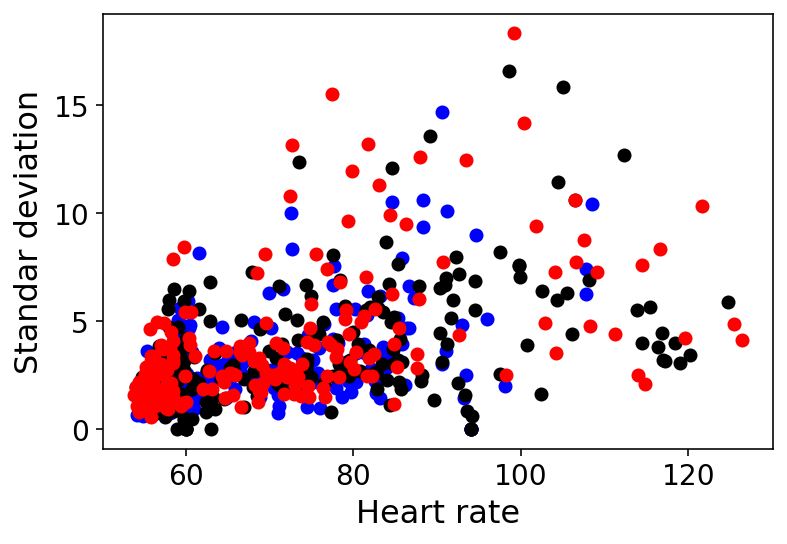

In [23]:
plt.scatter(means_31_8, stdevs_31_8, c = "b")
plt.scatter(means_01_9, stdevs_01_9, c="k")
plt.scatter(means_02_9, stdevs_02_9, c="r")
plt.xlabel("Heart rate")
plt.ylabel("Standar deviation") # Heart rate variability
plt.show()

Now comes the interesting part, cluster these datapoints!

Wait, before the clustering begins, I want to see how the time series looks with the correct time axis. Modify the previous functions accordingly.

# Clustering with k-means

The detail is that the code in HW4 is designed for minimizing the distance of a single array in 1D (voltage). In this case, you have 2D: heart rate and standard deviation. Modify the functions accordingly so to consider minimizing the distance to these 2 variables.

In [24]:
def iterative_cost_function(means, stdevs, mk_means, mk_stdevs, rnks): # Cost function for 1 cluster
    n = len(means)
    J = 0
    for i in range(n):
        if rnks[i]: 
            J += np.sum((means[i]-mk_means)**2 + (stdevs[i]-mk_stdevs)**2) #Sums the cost for the 2 dimensions
    return J


def all_clusters_cost_function(means, stdevs, mk_means, mk_stdevs, rnks): # Cost function for all clusters
    J = 0
    
    for cluster_i in range(len(mk_means)):
        J+= iterative_cost_function(means, stdevs, mk_means[cluster_i], mk_stdevs[cluster_i], rnks[cluster_i])
    return J

In [25]:
# Assigning a cluster based on distance between centroids and points:
def distances(means, stdevs, mk_means, mk_stdevs):
    number_of_clusters = len(mk_means) #3
    number_of_datapoints = len(means) # all the datapoints
    
    rnks_1 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_2 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_3 = np.zeros(number_of_datapoints, dtype = bool)
    
    for i in range(number_of_datapoints):
        distance = np.zeros(number_of_clusters)
        
        for cluster_i in range(number_of_clusters):
            distance[cluster_i]= np.sum((means[i]-mk_means[cluster_i])**2 + (stdevs[i]-mk_stdevs[cluster_i])**2)
            
        minimum = np.argmin(distance) # For assigning a cluster to each datapoint
        
        if minimum ==0: # Belongs in cluster 1
            rnks_1[i] = 1
        elif minimum ==1: # Belongs in cluster 2
            rnks_2[i] = 1
        elif minimum ==2: # Belongs in cluster 3
            rnks_3[i] = 1
    return rnks_1, rnks_2, rnks_3

In [26]:
# Trying out the distances function
means = means_31_8
stdevs = stdevs_31_8

pool = len(means)
mks_mean_init = [means[round(pool*random.random())], means[round(pool*random.random())],
                 means[round(pool*random.random())]]
mks_stdevs_init = [stdevs[round(pool*random.random())], stdevs[round(pool*random.random())],
                   stdevs[round(pool*random.random())]]

rnks_1, rnks_2, rnks_3 = distances(means, stdevs, mks_mean_init, mks_stdevs_init)

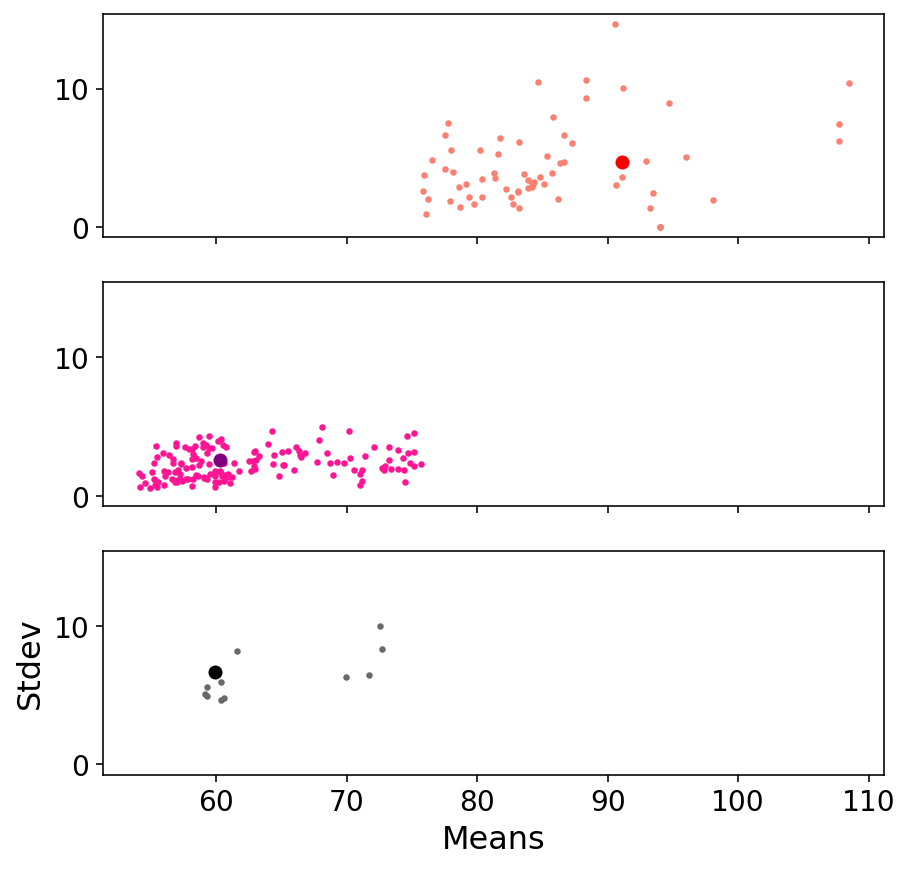

In [27]:
# First iteration

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(7,7))
# fig.suptitle('Neuron traces based on cluster', fontsize=20)

#     time = [i for i in range(40)]
size = 5
for i in range(len(means)):

    if rnks_1[i]:
        ax1.scatter(means[i], stdevs[i], color="salmon", s=size)

    elif rnks_2[i]:
        ax2.scatter(means[i], stdevs[i], color="deeppink", s=size)

    elif rnks_3[i]:
        ax3.scatter(means[i], stdevs[i], color="dimgrey", s=size)

ax1.scatter(mks_mean_init[0], mks_stdevs_init[0], c="r")
ax2.scatter(mks_mean_init[1], mks_stdevs_init[1], c="purple")
ax3.scatter(mks_mean_init[2], mks_stdevs_init[2], c="k")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

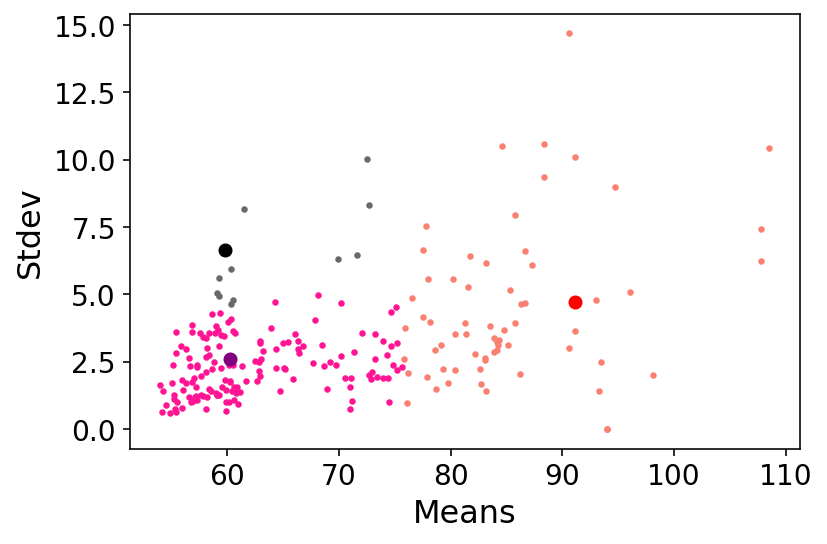

In [28]:
# First iteration
for i in range(len(means)):

    if rnks_1[i]:
        plt.scatter(means[i], stdevs[i], color="salmon", s=size)

    elif rnks_2[i]:
        plt.scatter(means[i], stdevs[i], color="deeppink", s=size)

    elif rnks_3[i]:
        plt.scatter(means[i], stdevs[i], color="dimgrey", s=size)

plt.scatter(mks_mean_init[0], mks_stdevs_init[0], c="r")
plt.scatter(mks_mean_init[1], mks_stdevs_init[1], c="purple")
plt.scatter(mks_mean_init[2], mks_stdevs_init[2], c="k")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

In [29]:
# Updating centroids
def updates_centroids(means, stdevs, rnks_1, rnks_2, rnks_3):
    c1_means = []
    c1_stdevs = []
    c2_means = []
    c2_stdevs = []
    c3_means = []
    c3_stdevs = []

    for i in range(len(means)):
#         print(i)
#         print("1 ", rnks_1)
#         print("2 ", rnks_2)
#         print("3 ", rnks_3)
        
        if rnks_1[i]:
            c1_means.append(means[i])
            c1_stdevs.append(stdevs[i])

        elif rnks_2[i]:
            c2_means.append(means[i])
            c2_stdevs.append(stdevs[i])

        elif rnks_3[i]:
            c3_means.append(means[i])
            c3_stdevs.append(stdevs[i])

    mks1_mean = np.mean(c1_means, 0)
    mks1_stdevs = np.mean(c1_stdevs, 0)
    
    mks2_mean = np.mean(c2_means, 0)
    mks2_stdevs = np.mean(c2_stdevs, 0)
    
    mks3_mean = np.mean(c3_means, 0)
    mks3_stdevs = np.mean(c3_stdevs, 0)
    
    return mks1_mean, mks1_stdevs, mks2_mean, mks2_stdevs, mks3_mean, mks3_stdevs

In [30]:
def one_iteration(means, stdevs, mks_mean_init, mks_stdevs_init):
    rnks_1, rnks_2, rnks_3 = distances(means, stdevs, mks_mean_init, mks_stdevs_init)
    mks1_mean, mks1_stdevs, mks2_mean, mks2_stdevs, mks3_mean, mks3_stdevs = updates_centroids(means, stdevs, rnks_1,
                                                                                               rnks_2, rnks_3)
    
    mks1_mean, mks1_stdevs, mks2_mean, mks2_stdevs, mks3_mean, mks3_stdevs = updates_centroids(means, stdevs, rnks_1,
                                                                                               rnks_2, rnks_3)
    
    mks_means = [mks1_mean, mks2_mean, mks3_mean]
    mks_stdevs = [mks1_stdevs, mks2_stdevs, mks3_stdevs]
    rnks = [rnks_1, rnks_2, rnks_3]
    
    J = all_clusters_cost_function(means, stdevs, mks_means, mks_stdevs, rnks)
    return J, rnks, mks_means, mks_stdevs

In [31]:
# Initializes with 3 random traces from the dataset
means = means_31_8
stdevs = stdevs_31_8

pool = len(means)
mks_mean_init = [means[round(pool*random.random())], means[round(pool*random.random())],
                 means[round(pool*random.random())]]
mks_stdevs_init = [stdevs[round(pool*random.random())], stdevs[round(pool*random.random())],
                   stdevs[round(pool*random.random())]]

J = []
i = 0
converging = False

J1, rnks_1, mk_means, mk_stdevs = one_iteration(means, stdevs, mks_mean_init, mks_stdevs_init) # First iteration
J.append(J1)

# while converging == False:
for k in range(10):
    J1, rnks, mk_means, mk_stdevs = one_iteration(means, stdevs, mk_means, mk_stdevs)
    J.append(J1)
    
    if np.abs(J[i-1]-J[i])< 0.0001*J[i]: # Finding the convergence value
        print("Converging value occurs in the ", i+1, "th iteration.")
        converging = True
    i +=1

In [32]:
J

[9775.044755969884,
 6804.312551706476,
 5291.3346159702105,
 5020.801456716481,
 4955.6740066262755,
 4916.31198585697,
 4909.844309956465,
 4908.390299930494,
 4905.127262070341,
 4901.587807141588,
 4901.587807141588]

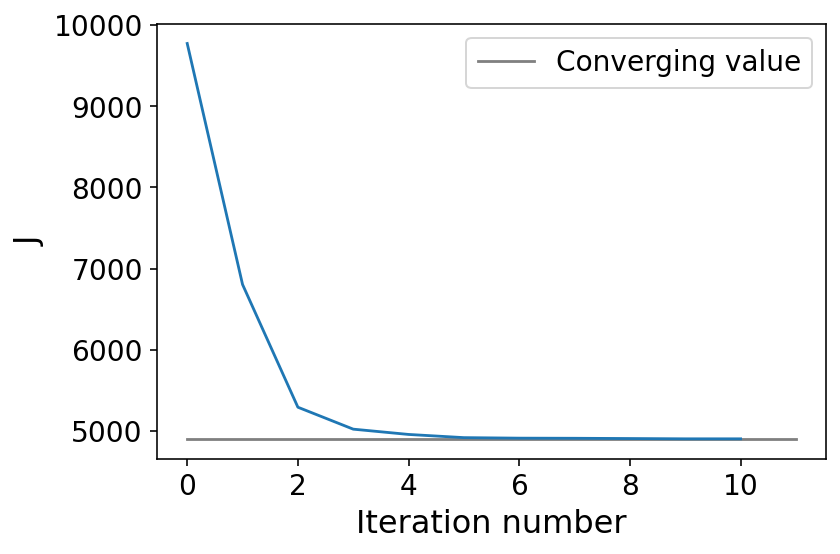

In [33]:
max_ind = len(J)
plt.plot([0,max_ind], [J[max_ind-1], J[max_ind-1]], label = "Converging value", color = "grey")
plt.plot(J)
plt.xlabel("Iteration number")
plt.ylabel("J")
plt.legend()
plt.show()

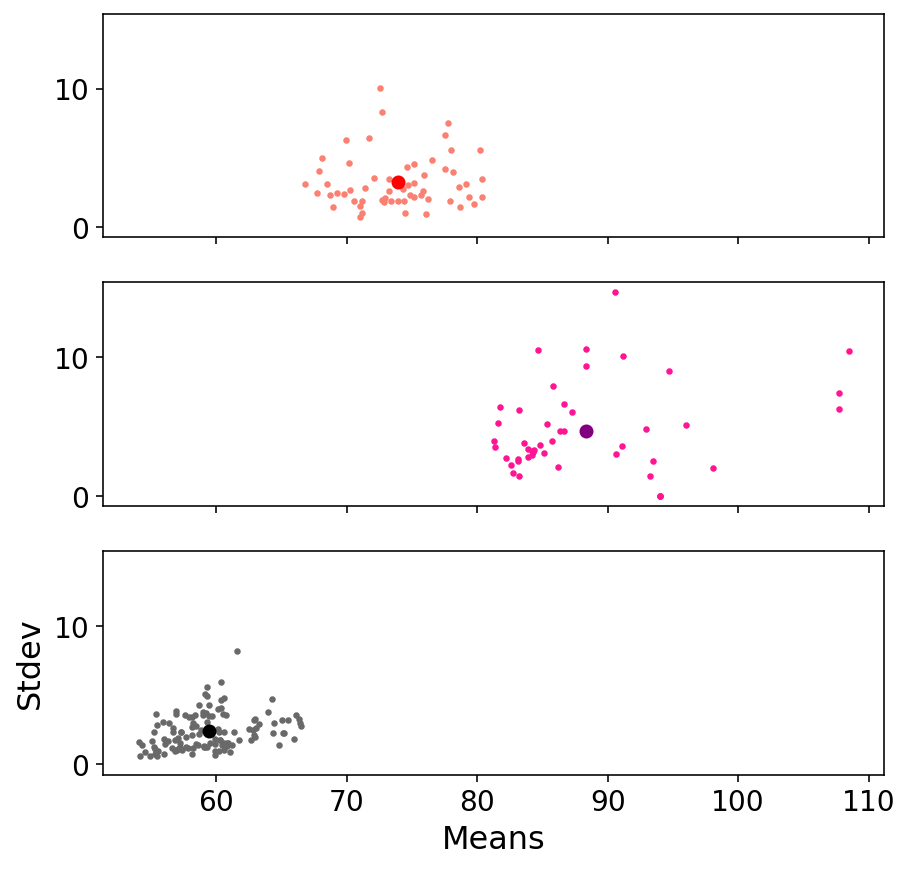

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(7,7))
# fig.suptitle('Neuron traces based on cluster', fontsize=20)

#     time = [i for i in range(40)]
size = 5
for i in range(len(means)):

    if rnks[0][i]: #mk_means, mk_stdevs
        ax1.scatter(means[i], stdevs[i], color="salmon", s=size)

    elif rnks[1][i]:
        ax2.scatter(means[i], stdevs[i], color="deeppink", s=size)

    elif rnks[2][i]:
        ax3.scatter(means[i], stdevs[i], color="dimgrey", s=size)

ax1.scatter(mk_means[0], mk_stdevs[0], c="r")
ax2.scatter(mk_means[1], mk_stdevs[1], c="purple")
ax3.scatter(mk_means[2], mk_stdevs[2], c="k")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

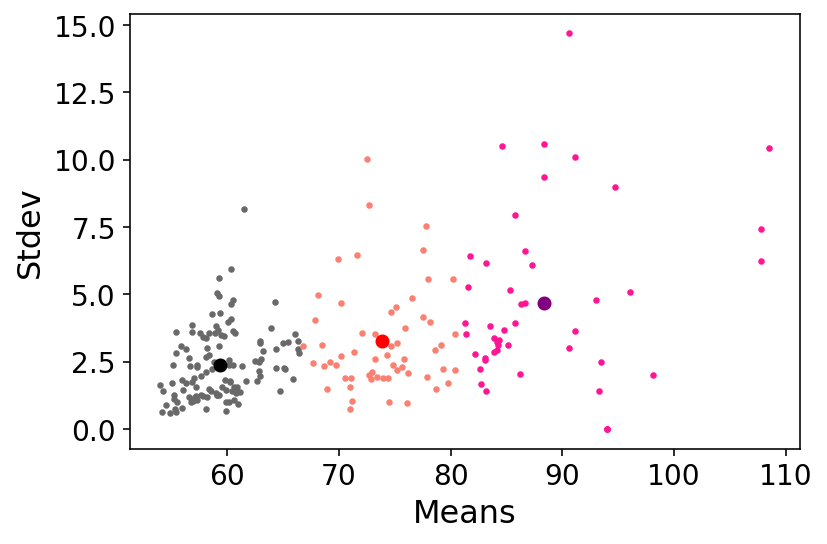

In [35]:
for i in range(len(means)):

    if rnks[0][i]: #mk_means, mk_stdevs
        plt.scatter(means[i], stdevs[i], color="salmon", s=size)

    elif rnks[1][i]:
        plt.scatter(means[i], stdevs[i], color="deeppink", s=size)

    elif rnks[2][i]:
        plt.scatter(means[i], stdevs[i], color="dimgrey", s=size)

plt.scatter(mk_means[0], mk_stdevs[0], c="r")
plt.scatter(mk_means[1], mk_stdevs[1], c="purple")
plt.scatter(mk_means[2], mk_stdevs[2], c="k")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

# What is the optimal number of clusters?

We could use the KMeans function already defined, but it would be nice if you modified the previous function.

In [36]:
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [37]:
ndata = [[means[i], stdevs[i]] for i in range(len(means))]

In [38]:
iterations = 15
J = np.zeros(iterations)

for K in range(2,iterations):
    print(K)
    kmeans = KMeans(n_clusters=K, random_state=0, algorithm="full").fit(ndata)
    J[K] = kmeans.inertia_ # This must be the cost function J

2
3
4
5
6
7
8
9
10
11
12
13
14


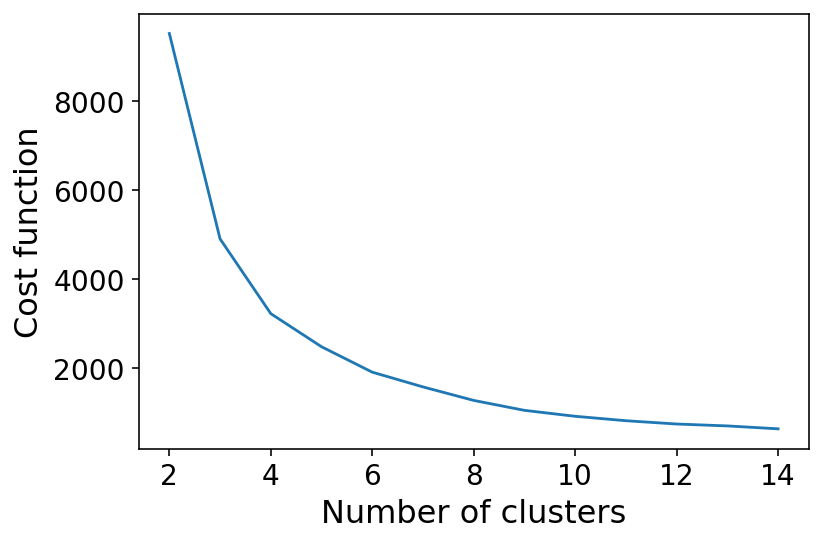

In [39]:
plt.plot([i+2 for i in range(13)], J[2:])
plt.xlabel("Number of clusters")
plt.ylabel("Cost function")
plt.show()

So the elbow of the previous curve is around 4 or 5 clusters. You must have a better argument than the visual clue. Try to use a threshold value or something for the cost function J. Maybe the derivative value falls below certain threshold.

In [40]:
K = 4
kmeans = KMeans(n_clusters=K, random_state=0, algorithm="full").fit(ndata)

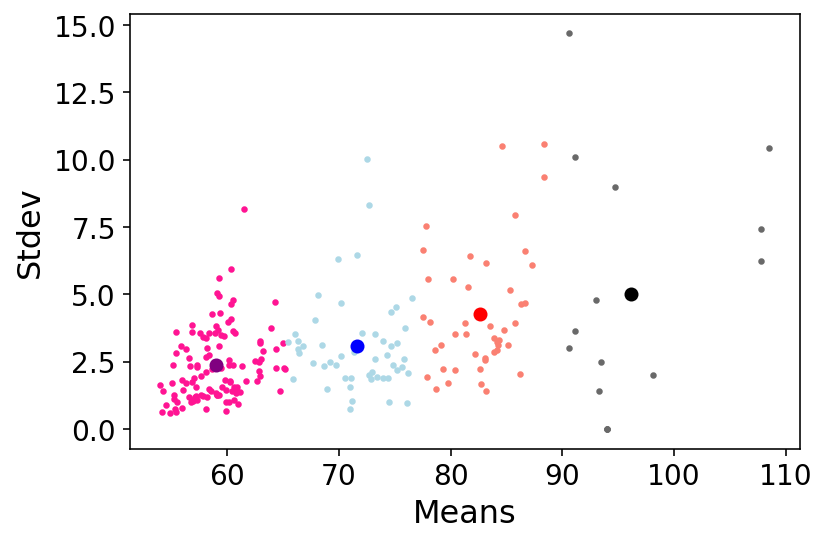

In [41]:
for i in range(len(kmeans.labels_)):

    if kmeans.labels_[i] == 0:
        plt.scatter(means[i], stdevs[i], color="salmon", s=size)

    elif kmeans.labels_[i] == 1:
        plt.scatter(means[i], stdevs[i], color="deeppink", s=size)

    elif kmeans.labels_[i] == 2:
        plt.scatter(means[i], stdevs[i], color="dimgrey", s=size)

    elif kmeans.labels_[i] == 3:
        plt.scatter(means[i], stdevs[i], color="lightblue", s=size)

    else:
        print("Something is worng in tieratio: ",i)

plt.scatter(kmeans.cluster_centers_[0,0], kmeans.cluster_centers_[0,1], c="r")
plt.scatter(kmeans.cluster_centers_[1,0], kmeans.cluster_centers_[1,1], c="purple")
plt.scatter(kmeans.cluster_centers_[2,0], kmeans.cluster_centers_[2,1], c="k")
plt.scatter(kmeans.cluster_centers_[3,0], kmeans.cluster_centers_[3,1], c="b")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

In [42]:
K = 5
kmeans = KMeans(n_clusters=K, random_state=0, algorithm="full").fit(ndata)

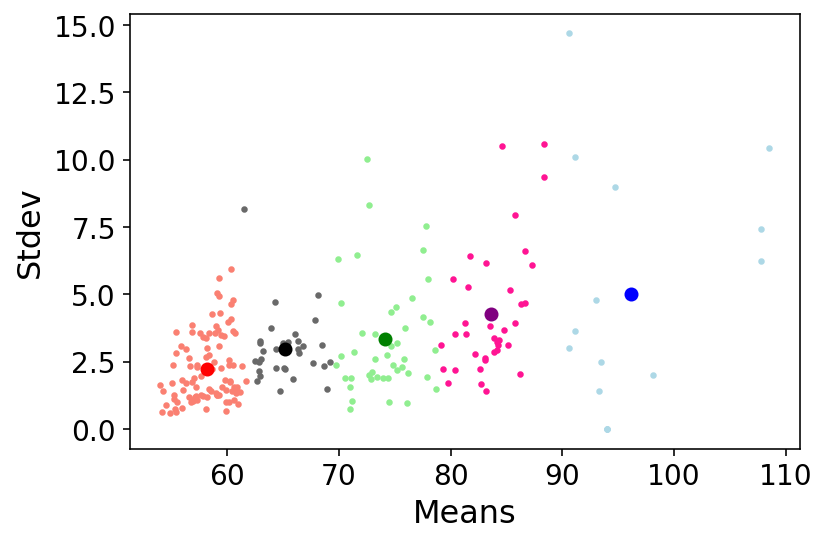

In [44]:
for i in range(len(kmeans.labels_)):

    if kmeans.labels_[i] == 0:
        plt.scatter(means[i], stdevs[i], color="salmon", s=size)

    elif kmeans.labels_[i] == 1:
        plt.scatter(means[i], stdevs[i], color="deeppink", s=size)

    elif kmeans.labels_[i] == 2:
        plt.scatter(means[i], stdevs[i], color="dimgrey", s=size)

    elif kmeans.labels_[i] == 3:
        plt.scatter(means[i], stdevs[i], color="lightblue", s=size)
        
    elif kmeans.labels_[i] == 4:
        plt.scatter(means[i], stdevs[i], color="lightgreen", s=size)

    else:
        print("Something is worng in tieratio: ",i)

plt.scatter(kmeans.cluster_centers_[0,0], kmeans.cluster_centers_[0,1], c="r")
plt.scatter(kmeans.cluster_centers_[1,0], kmeans.cluster_centers_[1,1], c="purple")
plt.scatter(kmeans.cluster_centers_[2,0], kmeans.cluster_centers_[2,1], c="k")
plt.scatter(kmeans.cluster_centers_[3,0], kmeans.cluster_centers_[3,1], c="b")
plt.scatter(kmeans.cluster_centers_[4,0], kmeans.cluster_centers_[4,1], c="green")
# plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

Does the optimal number of clusters change if we modify the time window considered to 1 min?

# The optimal number of clusters related with some physiological value.
Amount of exercise.
- Red one is when sleeping.
- Next one some activity when awake that is not vigorous, like taking a class, being in a desk.
- Next one could be like walking or such
- Next one riding a bike, dancing?

I am curious for the amount of stdev in some of the recordings, though.

How could you prove this? See the time when each opne of these occured and have notes of what kinds of activities you performed during certain time periods during the day.

Maybe the stadard deviation associated to each data cluster can be associated too with the amounbt of heart rate variability or healthiness of a person? I do not know, some of the dots with high standard deviation must be due to noise or artifacts. But there must be some intrinsic variability of the heart which must be related to health.

# Review and modify based on Della's comments in this NB

Della:
- Q1. (-3) Recall that you are using argmax(x[5:25]), you need to add 5 back to the argmax index when extracted peak values
- Q4. (-5) The idea is right but you had the same mistake as Q1 so the peaks you were using are wrong.
- Q5. b. (-2) Distance should be computed as the euclidean distance rather than L1 norm c. (-5) The datapoints at the boundary of clusters should have minimum euclidean distance to all 2/3/4 centers 


Comments about HW3:

Q1. Actually I would prefer to call the 'lambda' you computed in each trial as firing rate since you haven't done any averaging across trials yet. (-1) To avoid error of log(lambda=0), replace lambda with small value like 1e-5. Setting 'log_term = -230*x_d' doesn't seem to be a good way to go. Q2. Nice figures and labeling. Don't literally need to include movement data. 2b, (-3) Lack of description and explaination on your results. Q3. (-5) Since you are randomly droping neurons, you need to randomly drop them by 20 times. Then estimate the mean and variations of decoding accuracy. You'll find your curve (decoding accuracy vs. number of dropped neurons) much smoother. 

Comments on HW5:
Q1. a. (-4) sklearn PCA input data X should be of shape (n_samples, n_features). pca.explained_variance_ is the eigenvalue, not pca.singular_values_. You did it right in b and c, I am confused why you did (a) differently :0 Q2. e. (-3) For all channel data, you shouldn't truncate eigenvectors_160 while computing projections. This is why you are computing total_var_backprojection_160 wrong Q3. a. (-1) The assumed noise would draw the projected points closer to their mean b. (-5) You result didn't look right. While estimating new psi, you need to use np.diag(np.diag()) to get the diagonal of the matrix. Further, if you run the FA multiple times with different random psi initializations, you will find FA gives multiple local optimums. 